In [147]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Crawl Data

In [136]:
def scrape(sites: list, 
           columns: list,
           tr_offset_first=None, 
           tr_offset_last=None,
           td_offset_first=None,
           td_offset_last=None):
    
    dfs = []
    
    for site in sites:
        # Make request
        response = requests.get(site['url'])
        content = response.content.decode('utf-8')

        # Make soup 
        soup = BeautifulSoup(content, 'html.parser')

        # Get table
        table = soup.find('span', {'id': site['table_id']}).find_next('table')

        # Get rows
        trs = table.find_all('tr')[tr_offset_first : tr_offset_last]

        # Get values
        results = []
        for tr in trs:
            # init new dict
            result = {}

            # get value list
            tds = tr.find_all('td')[td_offset_first : td_offset_last]

            for k, td in zip(columns, tds):
                result[k] = td.text.strip()

            # append to master result
            results.append(result)

        # Convert to DataFrame
        df = pd.DataFrame(results)
        df['country'] = site['country']
        dfs.append(df)
        
    df = pd.concat(dfs)
    df = df.reset_index(drop=True)
    df = df[df['dob'].isnull()==False]
    df = df[df['dob']!='']
        
    return df

In [137]:
sites = [
    {'url': 'https://en.wikipedia.org/wiki/Brazil_national_under-17_football_team',
     'table_id': 'Current_squad',
     'country': 'Brazil'},
    {'url': 'https://en.wikipedia.org/wiki/England_national_under-17_football_team',
     'table_id': 'Players',
     'country': 'England'},
    {'url': 'https://en.wikipedia.org/wiki/Germany_national_youth_football_team',
     'table_id': 'Germany_national_under-17_squad',
     'country': 'Germany'},
    {'url': 'https://en.wikipedia.org/wiki/Italy_national_under-17_football_team',
     'table_id': 'Current_squad',
     'country': 'Italy'},
    {'url': 'https://en.wikipedia.org/wiki/France_national_under-17_football_team',
     'table_id': 'Current_squad',
     'country': 'France'},
    {'url': 'https://en.wikipedia.org/wiki/Portugal_national_under-17_football_team',
     'table_id': 'Current_squad',
     'country': 'Portugal'},
    {'url': 'https://en.wikipedia.org/wiki/Vietnam_national_under-17_football_team',
     'table_id': 'Current_squad', 
     'country': 'Vietnam'},
]

df = scrape(sites=sites,
            columns=['position', 'dob'],
            tr_offset_first=1,
            td_offset_first=1,
            td_offset_last=3)

len(df)

127

# Process Data

In [145]:
def convert_date(text):
    # find dob in format yyyy-mm-dd
    dob = re.findall('\d+-\d+-\d+', text)[0]
    
    # convert to datetime
    date_converted = datetime.strptime(dob, '%Y-%m-%d')
    
    return date_converted

In [139]:
df['dob_converted'] = df['dob'].apply(convert_date)

In [140]:
df['mob'] = pd.DatetimeIndex(df['dob_converted']).month

In [141]:
df.head()

,position,dob,country,dob_converted,mob
0,1GK,(2002-05-17) 17 May 2002 (age 19),Brazil,2002-05-17,5
1,1GK,(2002-12-20) 20 December 2002 (age 18),Brazil,2002-12-20,12
2,1GK,(2002-02-25) 25 February 2002 (age 19),Brazil,2002-02-25,2
4,2DF,(2002-06-03) 3 June 2002 (age 19),Brazil,2002-06-03,6
5,2DF,(2002-02-19) 19 February 2002 (age 19),Brazil,2002-02-19,2


# Quick check

In [150]:
agg = df.groupby(['mob', 'country'])['dob'].count().reset_index(name='players')
agg

,mob,country,players
0,1,Brazil,6
1,1,England,5
2,1,France,2
3,1,Germany,3
4,1,Italy,1
...,...,...,...
57,11,Vietnam,1
58,12,Brazil,1
59,12,England,1
60,12,Italy,1


<AxesSubplot:xlabel='mob', ylabel='players'>

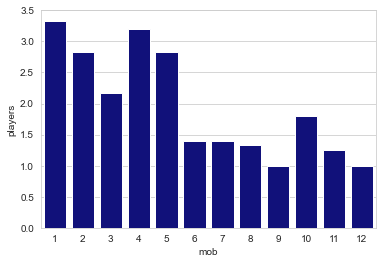

In [161]:
sns.barplot(data=agg, x='mob', y='players', color='DarkBlue', ci=None)

In [153]:
agg_pivot = pd.pivot_table(agg, values='players', index='mob', columns='country')

array([[<AxesSubplot:title={'center':'Brazil'}, xlabel='mob'>,
        <AxesSubplot:title={'center':'England'}, xlabel='mob'>,
        <AxesSubplot:title={'center':'France'}, xlabel='mob'>],
       [<AxesSubplot:title={'center':'Germany'}, xlabel='mob'>,
        <AxesSubplot:title={'center':'Italy'}, xlabel='mob'>,
        <AxesSubplot:title={'center':'Vietnam'}, xlabel='mob'>]],
      dtype=object)

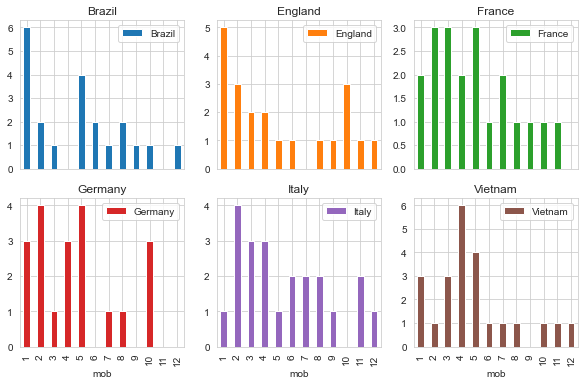

Executing shutdown due to inactivity...


2021-08-07 12:13:39,696 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2021-08-07 12:13:40,036 - INFO     - Executing shutdown...


In [164]:
agg_pivot.plot(kind='bar', subplots=True, layout=(2,3), figsize=(10,6))

# Export

In [157]:
df.to_csv('young_footballer.csv')